In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")

tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

fwave = r.TFile("./data/waveforms.root")
twave = fwave.Get("islands").Get("islands").Get("islandTree")

In [3]:
from evwTools import *

Unique island:  1636400282000020001100079
     Found another island with this unique ID. Adding their crystals together:
           [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
           [25.0, 26.0, 34.0, 35.0, 43.0, 44.0, 25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
     Found Match ( 1000 0 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0, 25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [35.0]


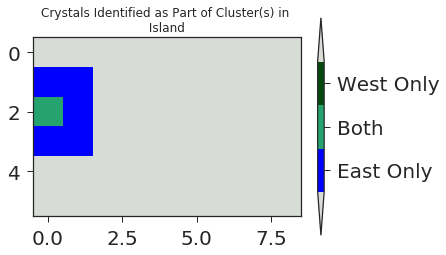

Unique island:  1636400282000020001100088
     Found another island with this unique ID. Adding their crystals together:
           [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
           [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
     Found Match ( 1001 0 1 )
         East:  [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
         West:  [33.0, 13.0, 22.0, 32.0]


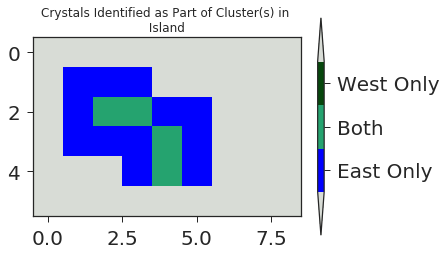

In [11]:
dingbefore = 0

for i, entry in enumerate(teast):
    
    if i < 1000:
        continue
    if i > 1001:
        break
    
    counter = 0
    ding = constructUniqueIDeast(entry)
    if (dingbefore == ding):
        continue
        
    print("Unique island: ", ding)
    
    crystalsEast = [x for x in entry.crystalsEast]
    fout = r.TFile("temp_tree_storage.root","recreate")
    
    teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(ding) )
    for k, entry3 in enumerate(teast_partial):
        dong = constructUniqueIDeast(entry3)
        if ding == dong:
            print("     Found another island with this unique ID. Adding their crystals together:")
            print("          ",crystalsEast)
            crystalsEast += [x for x in entry3.crystalsEast]
            print("          ",crystalsEast)
    
    crystalsWest = []
    twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(ding) )
    for j, entry2 in enumerate(twest_partial):
        dong = constructUniqueIDwest(entry2)
        if (ding == dong):
            counter = counter + 1
            print("     Found Match (", i, j, counter,")")
            print("         East: ", crystalsEast)
            print("         West: ", [x for x in entry2.crystalsWest])
            crystalsWest += [x for x in entry2.crystalsWest]
            
    imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)

    dingbefore = ding

In [5]:
vecX = []

fout = r.TFile("temp_tree_storage.root","recreate")
tcomp_cut = tcomp.CopyTree( "TMath::Abs(deltaX) > 4" )

for i, entry in enumerate(tcomp_cut):
    print(constructUniqueID(entry))
    crystalsEast = entry.crystalsEast
    crystalsWest = entry.crystalsWest

    vecX.append( ([x for x in crystalsEast] , [x for x in crystalsWest]) )

1636400282000290000100186
1636400282000860000300180
1636400282000860002100118
1636400282001500002000161
1636400282001580000200103
1636400282001970000700162


In [6]:
print(len(vecX))
print(vecX)

6
[([7.0, 8.0, 16.0, 17.0], [8.0, 1.0]), ([27.0, 28.0, 36.0, 37.0, 45.0, 46.0], [44.0, 36.0]), ([27.0, 28.0, 36.0, 37.0, 45.0, 46.0], [42.0, 36.0, 44.0]), ([9.0, 10.0, 18.0, 19.0, 27.0, 28.0], [18.0, 44.0, 43.0]), ([9.0, 10.0, 18.0, 19.0, 27.0, 28.0], [26.0, 17.0, 18.0]), ([0.0, 1.0, 9.0, 10.0, 11.0, 12.0, 18.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0], [26.0, 9.0, 20.0, 11.0, 44.0])]


([7.0, 8.0, 16.0, 17.0], [8.0, 1.0])


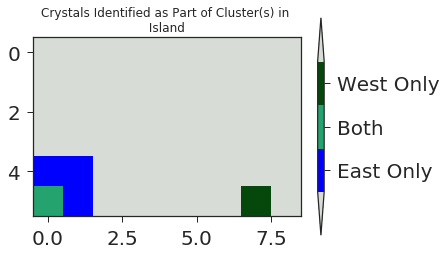

([27.0, 28.0, 36.0, 37.0, 45.0, 46.0], [44.0, 36.0])


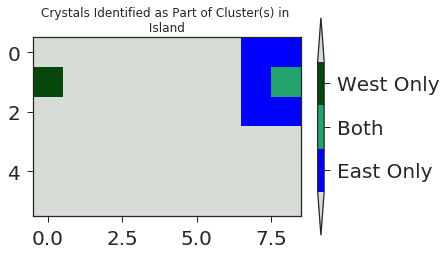

([27.0, 28.0, 36.0, 37.0, 45.0, 46.0], [42.0, 36.0, 44.0])


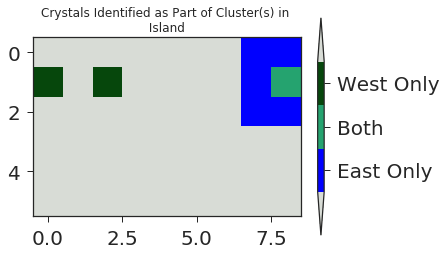

([9.0, 10.0, 18.0, 19.0, 27.0, 28.0], [18.0, 44.0, 43.0])


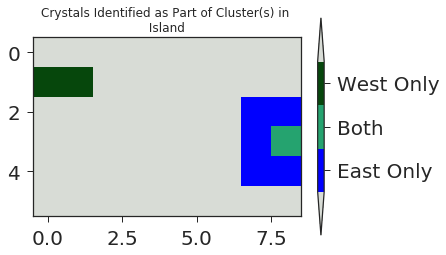

([9.0, 10.0, 18.0, 19.0, 27.0, 28.0], [26.0, 17.0, 18.0])


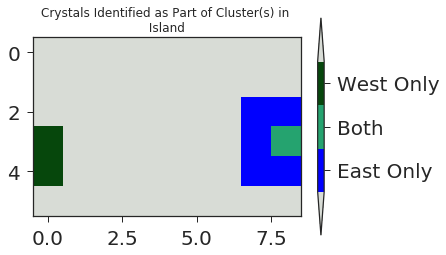

([0.0, 1.0, 9.0, 10.0, 11.0, 12.0, 18.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0], [26.0, 9.0, 20.0, 11.0, 44.0])


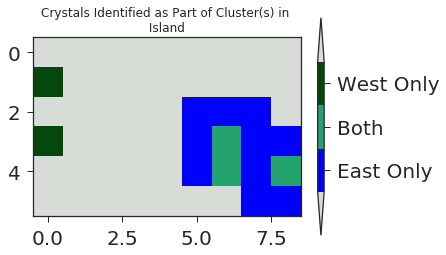

In [7]:
for entry in vecX:
    print(entry)
    cw = entry[1]
    ce = entry[0]
    
    imshowCompare( toMap(ce), toMap(cw), True, ding)

East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 1, 1, 1, 0], [1, 1, 1, 0, 0, 1, 1, 1, 0], [1, 1, 1, 0, 0, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1


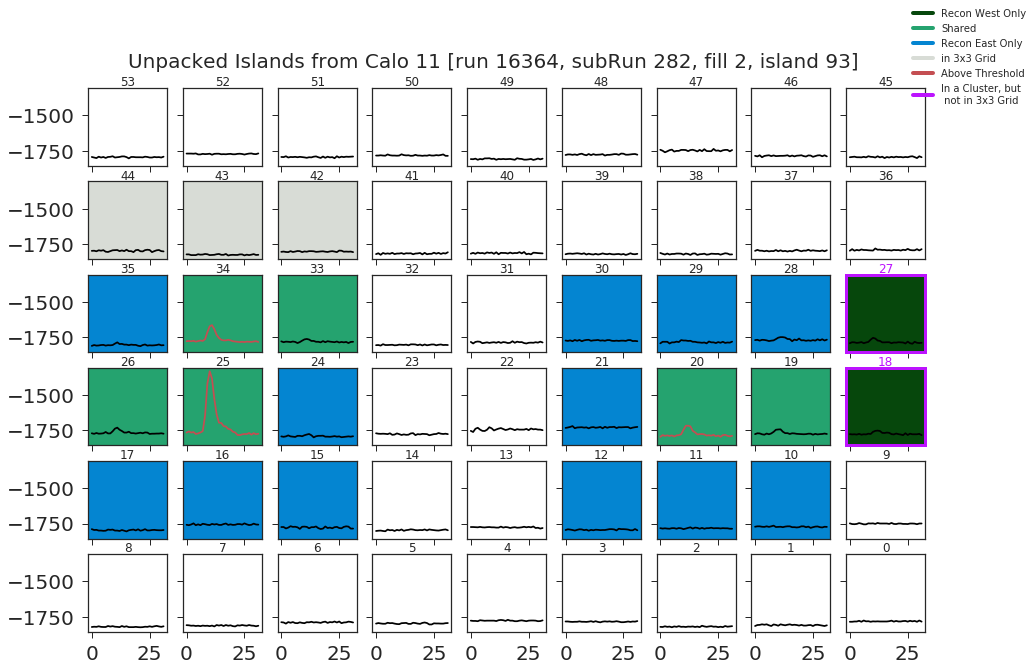

In [8]:
uniqueIDref = 1636400282000020001100093
islandPlot(uniqueIDref, teast, twest, twave, saveImage = True)

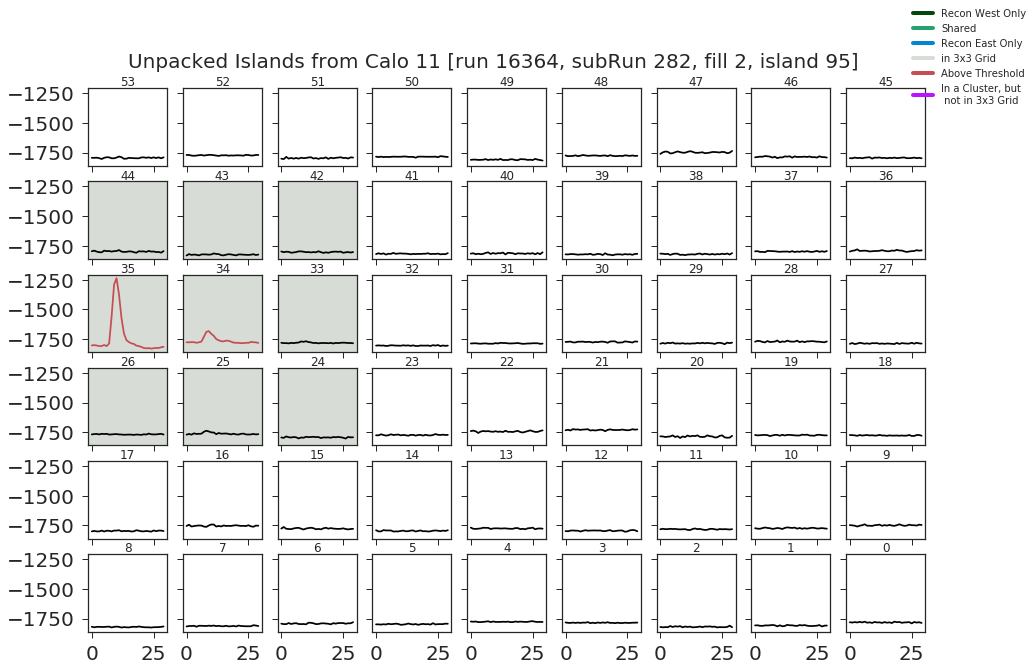

In [9]:
uniqueIDref = 1636400282000020001100095
islandPlot(uniqueIDref, teast, twest, twave, saveImage = True)

In [8]:
counter = 0

fout = r.TFile("temp_tree_storage.root","recreate")
tcomp_partial = tcomp.CopyTree( "deltaX > 3 && deltaY > 0" )
print("Found", tcomp_partial.GetEntries(),"clusters")

for i, entry in enumerate(tcomp_partial):
    counter += 1
    if counter > 5:
        break
    print(constructUniqueID(entry), "(",counter,")")
    islandPlot(constructUniqueID(entry), teast, twest, twave, True)
    print("West:", entry.energyWest,"; East:", entry.energyEast)
    print("deltaT (corrected):", entry.deltaT - entry.timeCorr)
    print("deltaX / deltaY:", entry.deltaX, "/", entry.deltaY)
    print("******************************************************************************************************")

Found 9 clusters
1592100222000350001500171 ( 1 )
West: 179.70896661264555 ; East: 102.4312279557882
deltaT (corrected): -0.19465082440990955
deltaX / deltaY: 3.4646962587293304 / 0.11277151880469027
******************************************************************************************************
1592100222000350002200134 ( 2 )
West: 547.1301148180381 ; East: 286.88464883956016
deltaT (corrected): 0.033138501763460226
deltaX / deltaY: 3.3070634020353653 / 0.4201576592678915
******************************************************************************************************
1592100222000420002400145 ( 3 )
West: 314.4529053635199 ; East: 186.43644573419837
deltaT (corrected): -0.025621825020760297
deltaX / deltaY: 4.149222214441027 / 0.18133089215478382
******************************************************************************************************
1592100222000540000700169 ( 4 )
West: 221.6925351993679 ; East: 167.82299523559584
deltaT (corrected): -0.14942371494008694
delta